# 1. Prepare environment and download data

### 1.1 Import required modules

In [1]:
from sklearn.datasets._lfw import fetch_lfw_people
from sklearn.utils import Bunch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

## 1.2 Fetch lfw data

In [2]:
lfw_people: Bunch = fetch_lfw_people(min_faces_per_person=70, resize=0.4) #type: ignore

In [3]:
print(lfw_people['data'].shape) # flatten data (2D), each row corresponding to an image
print(lfw_people['images'].shape) # 3D data, each image is an w * h matrix
print(lfw_people['target'].shape) # labels associated to each face, in this case only 4 persons
print(lfw_people['target_names'].shape)

(864, 1850)
(864, 50, 37)
(864,)
(4,)


## 1.3 Plot some image of data set

In [4]:
def plot_gallery(images, titles, n_row=3, n_col=4) -> None:
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [133]:
target_names = lfw_people.target_names
# print(target_names)
# print(type(target_names))
# print(target_names[lfw_people.target])
# print(type(target_names[lfw_people.target]))
target_names

array(['Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder',
       'Tony Blair'], dtype='<U17')

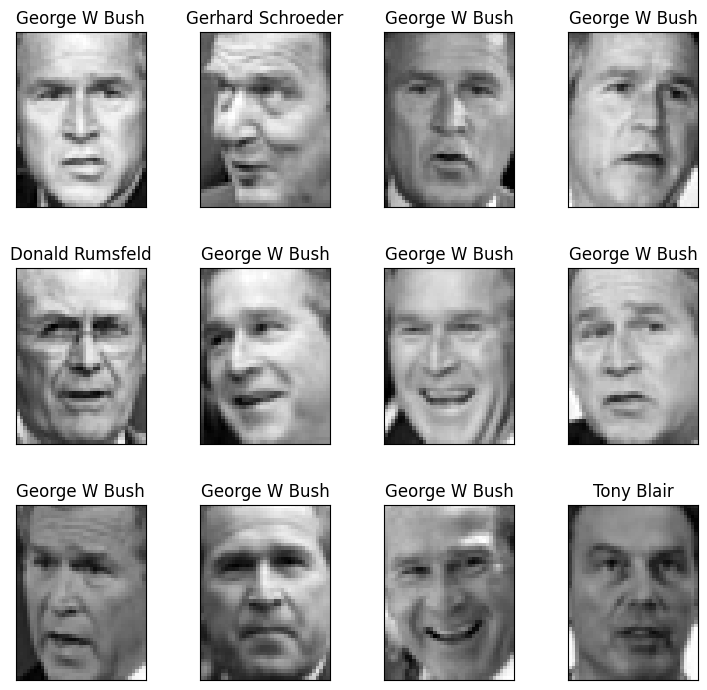

In [6]:
plot_gallery(lfw_people.images, target_names[lfw_people['target']])
plt.show()

# 2. Preprocessing data

In [16]:
type(input_shape)
n_classes
input_shape

(50, 37, 1)

In [ ]:
n_samples, h, w = lfw_people['images'].shape
input_shape = (h, w, 1)
n_classes = len(target_names)
images: np.ndarray = lfw_people.images
# Modify images from 3D to 4D for CNN
x = images.reshape(n_samples, h, w, 1)

# Pixel normalization [0, 1] data already normalization
# x = x.astype('float32') / 255.0

# Labels encoding (one-hot)
y = lfw_people.target
y = tf.keras.utils.to_categorical(y, num_classes=n_classes)

# Split data to train, val and test
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"{x_train.shape}") # (n_samples_train, h, w, 1)
print(f"{y_train.shape}") # (n_samples_train, n_classes)

In [21]:
y

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], shape=(864, 4))

# 3. Build CNN architecture from scratch

In [124]:
from tensorflow.keras import layers
from tensorflow.keras import models, layers, regularizers

def build_cnn_model(input_shape, num_classes):

    # Apply data augmentation
    data_augmentation = models.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1)
    ])

    # Initialize model with sequential layers
    model = models.Sequential()


    # Add input shape
    model.add(layers.Input(shape=input_shape)) # (50, 37, 1)

    model.add(data_augmentation)

    # Layer convolutional 1
    model.add(layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        activation='relu',
        padding='valid',
    )) # (48, 35)
    # Pooling 1
    model.add(layers.MaxPooling2D((2, 2))) # (24, 17)

    # Layer convol 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    # Pooling 2
    model.add(layers.MaxPooling2D((2, 2)))

    # Layer convol 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    # Pooling 3
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattend data for fully connected layer
    model.add(layers.Flatten())

    # Layer Fully Connected (Dense)
    model.add(layers.Dense(
        units=128,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    ))
    model.add(layers.Dropout(rate=0.5)) # overfitting

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


input_shape = (h, w, 1)
model = build_cnn_model(input_shape, n_classes)

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_47 (Sequential)      │ (None, 50, 37, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 48, 35, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 24, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 22, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 11, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 9, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,388 (876.52 KB)

 Trainable params: 224,388 (876.52 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Tranning model

## 4.1 Apply early stopping

In [126]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,       
    patience=8,        
    min_lr=1e-6,      
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
) 

In [127]:
history = model.fit(x_train, y_train,
                    epochs=200, 
                    batch_size=32, 
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5962 - loss: 2.7853 - val_accuracy: 0.6092 - val_loss: 2.0947 - learning_rate: 0.0010
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6136 - loss: 1.7998 - val_accuracy: 0.6092 - val_loss: 1.5012 - learning_rate: 0.0010
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6136 - loss: 1.3933 - val_accuracy: 0.6092 - val_loss: 1.2773 - learning_rate: 0.0010
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6136 - loss: 1.2434 - val_accuracy: 0.6092 - val_loss: 1.1963 - learning_rate: 0.0010
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6136 - loss: 1.1901 - val_accuracy: 0.6092 - val_loss: 1.1570 - learning_rate: 0.0010
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6136 - loss: 1.1664 - val_accuracy: 0.6092 - val_loss: 1.1209 - learning_rate: 0.0010
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6136 - loss: 1.1330 - 

# 5. Model evaluate


Test Loss: 0.4820
Test Accuracy: 0.8605


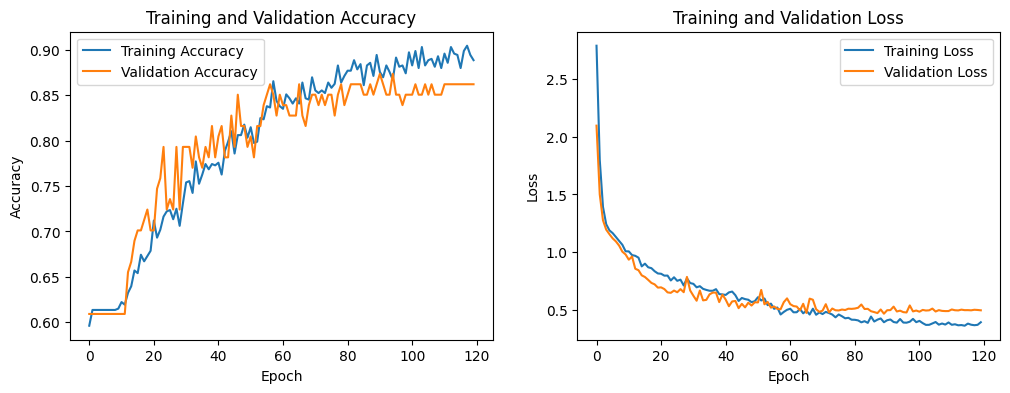

In [128]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Vẽ biểu đồ Accuracy và Loss qua các epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7. Report

In [77]:
import os
import pandas as pd
from datetime import datetime


def generate_report(history, model, x_test, y_test):
    # --- BƯỚC 1: TÌM EPOCH TỐT NHẤT ---
    # Tìm index của epoch mà tại đó val_loss là thấp nhất
    # Đây chính là epoch mà Early Stopping chọn để restore weights
    best_epoch_idx = np.argmin(history.history['val_loss'])
    
    # Lấy các chỉ số tại đúng epoch đó
    val_acc_best = history.history['val_accuracy'][best_epoch_idx]
    val_loss_best = history.history['val_loss'][best_epoch_idx]
    
    # Đánh giá trên tập Test (Model hiện tại đã là best weights nhờ restore_best_weights=True)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Đặt tên folder: dùng val_acc tại epoch tốt nhất (vc_best) và test_accuracy
    # Thêm thông tin epoch vào tên folder để dễ quản lý
    folder_name = f"model_ep{best_epoch_idx+1}_ts{test_accuracy*100:.1f}_vc{val_acc_best*100:.1f}"
    report_dir = f"../reports/{folder_name}"
    
    os.makedirs(f"{report_dir}/figures", exist_ok=True)

    # --- BƯỚC 3: VẼ VÀ LƯU BIỂU ĐỒ ---
    plt.figure(figsize=(12, 4))
    
    # Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    # Vẽ điểm Best Epoch để đánh dấu
    plt.scatter(best_epoch_idx, val_acc_best, color='green', s=100, label='Best Epoch', zorder=5)
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Acc ({test_accuracy:.2f})')
    plt.title('Accuracy Progress')
    plt.legend()

    # Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    # Vẽ điểm Best Epoch để đánh dấu
    plt.scatter(best_epoch_idx, val_loss_best, color='green', s=100, label='Best Epoch', zorder=5)
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss ({test_loss:.2f})')
    plt.title('Loss Progress')
    plt.legend()
    
    plt.savefig(f"{report_dir}/figures/learning_curves.png")
    plt.close()

    # --- BƯỚC 4: TẠO FILE BÁO CÁO MARKDOWN ---
    with open(f"{report_dir}/summary_report.md", "w", encoding="utf-8") as f:
        f.write(f"# Báo cáo thí nghiệm ML - {timestamp}\n\n")
        f.write(f"## 1. Kết quả tại Best Epoch (Epoch {best_epoch_idx + 1})\n")
        f.write(f"- **Test Accuracy:** {test_accuracy*100:.2f}%\n")
        f.write(f"- **Test Loss:** {test_loss:.4f}\n")
        f.write(f"- **Best Validation Accuracy:** {val_acc_best*100:.2f}%\n")
        f.write(f"- **Best Validation Loss:** {val_loss_best:.4f}\n\n")
        f.write(f"## 2. Biểu đồ huấn luyện\n")
        f.write(f"![Learning Curves](figures/learning_curves.png)\n\n")
        f.write(f"## 3. Kiến trúc mô hình\n")
        f.write("```\n")
        model.summary(print_fn=lambda x: f.write(x + '\n'))
        f.write("```\n")
        
    model.save(f"{report_dir}/model.keras")
    print(f"✅ Đã tạo xong report tại: {report_dir}")

In [ ]:
generate_report(history=history, model=model, x_test=x_test, y_test=y_test)